In [26]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from HelperAndMechanics import *
from matplotlib import cm
from ipywidgets import *
import seaborn as sns
import pandas as pd

plt.rcParams['text.usetex'] = True
# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [56]:
def list_groups(file_path):
    """Returns a list of the first-layer group names in an HDF5 file (direct children of root)."""
    with h5py.File(file_path, 'r') as f:
        return [name for name in f if isinstance(f[name], h5py.Group)]

def load_run(file_path, run):
    """Reads the data and parameters from a saved HDF5 file."""
    data = {}
    params_dict = {}
    
    with h5py.File(file_path, 'r') as f:
        if run not in f:
            raise ValueError(f"Run '{run}' not found in file.")
        
        group = f[run]
        
        # Load datasets (if available)
        dataset_keys = ['u_sol', 'u', 'v_sol', 'v', 'T_sol', 'T', 'x_sol', 'x',
                        'u_BOCF', 'v_BOCF', 'T_BOCF', 'x_BOCF','losses']
        
        for key in dataset_keys:
            if key in group:
                data[key] = np.array(group[key])
        
        # Load attributes from 'params_train' subgroup
        if "params_train" in group:
            params_group = group["params_train"]
            params_dict = {key: params_group.attrs[key] for key in params_group.attrs}
    
    return data, params_dict

def load_stat_data(file_path, mode='AP_AP'):
    """
    Load the data from the HDF5 file and return the datasets and parameters.
    
    Parameters:
        file_path (str): Path to the HDF5 file.
        mode (str): Mode of operation ('AP_AP' or 'BOCF').
    
    Returns:
        u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params, losses
    """
    run_list = list_groups(file_path)
    print("Available runs:", len(run_list))

    # Initialize storage lists
    u_sol, u_sim = [], []
    v_sol, v_sim = [], []
    T_sol, T_sim = [], []
    x_sol, x_sim = [], []
    losses = []
    params = {}

    for run in run_list:
        data, params_train = load_run(file_path, run)

        if not params:  # Initialize parameter dictionary once
            params = {key: [] for key in params_train.keys()}

        if mode == 'AP_AP':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x', np.array([])))
            if 'losses' in data:
                losses.append(data.get('losses', np.array([])))

        elif mode == 'BOCF':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u_BOCF', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v_BOCF', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T_BOCF', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x_BOCF', np.array([])))
            if 'losses' in data:
                lossoss = data['losses']

        # Append parameters
        for key in params_train.keys():
            params[key].append(params_train[key])

    # Convert lists to NumPy arrays
    return (
        np.concatenate(u_sol) if u_sol else np.array([]),
        np.concatenate(u_sim) if u_sim else np.array([]),
        np.concatenate(v_sol) if v_sol else np.array([]),
        np.concatenate(v_sim) if v_sim else np.array([]),
        np.concatenate(T_sol) if T_sol else np.array([]),
        np.concatenate(T_sim) if T_sim else np.array([]),
        np.concatenate(x_sol) if x_sol else np.array([]),
        np.concatenate(x_sim) if x_sim else np.array([]),
        losses,
        # np.concatenate(losses) if losses else np.array([]),
        {key: np.array(val) for key, val in params.items()}
    )

def plot_loss_curves(losses): 
    fig, ax = plt.subplots(2, 1, figsize=(8, 8))
    epochs = np.linspace(0, len(losses[0])*10, len(losses[0]))
    # Plot log(loss) curves
    for run in range(len(losses)):
        ax[0].plot(epochs,np.log(losses[run]))
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('log(Loss)')
    # ax[0].set_title('Loss over Epochs')

    # Plot min log(loss) for each run
    min_losses = [np.min(np.log(losses[run])) for run in range(len(losses))]
    ax[1].plot(min_losses, marker='o')
    ax[1].set_xlabel('Run')
    ax[1].set_ylabel('Min log(loss)')
    # ax[1].set_title('Minimum log(loss) per Run')

    plt.tight_layout()
    plt.show()

def violin_plot(file_path, mode, selected_keys, params_true, param_labels, title="Normalized Parameters"):
    """
    Generates a violin plot for selected parameters normalized by their true values.

    Parameters:
        file_path (str): Path to the HDF5 file.
        mode (str): Mode of operation ('AP_AP' or 'BOCF').
        selected_keys (list): List of parameter names to include in the plot.
        params_true (dict): Dictionary of true parameter values for normalization.
    """
    # Load data
    _, _, _, _, _, _, _, _, losses, params = load_stat_data(file_path, mode)

    # Normalize selected parameters
    normalized_params = {}
    for key in selected_keys:
        if key in params and key in params_true:
            normalized_params[key] = params[key] / params_true[key]

    # Convert to DataFrame
    df = pd.DataFrame(normalized_params)

    # Create the violin plot
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(data=df, inner="quartile", palette="coolwarm")
    sns.stripplot(data=df, color='black', jitter=True, alpha=0.5, zorder=3)

    # Add grid in the background
    plt.grid(True, linestyle="--", alpha=0.6, zorder=0)

    # Rotate x-axis labels
    plt.xticks(rotation=0)
    plt.ylabel('Normalized Value')
    plt.title(title)

    # Find x-axis tick positions and labels
    xticks = ax.get_xticks()
    xticklabels = [param_labels[tick.get_text()] for tick in ax.get_xticklabels()]
    # Find the indices of labels starting with 'k'
    ax.set_xticklabels(xticklabels)
    k_indices = [i for i, label in enumerate(xticklabels) if label== param_labels['k_ij']]
    
    if k_indices:
        x_start = -.1
        x_end = 2 +.1
        y_min = ax.get_ylim()[0]

        # Draw a straight line under the 'k' parameters
        ax.plot([x_start, x_end], [y_min + 0.05, y_min + 0.05], color='black', linewidth=1.5)

        # Add short vertical ticks at each end to simulate a brace
        ax.plot([x_start, x_start], [y_min + 0.05, y_min], color='black', linewidth=1.5)
        ax.plot([x_end, x_end], [y_min + 0.05, y_min], color='black', linewidth=1.5)

        # Add a text label below the line
        ax.text((x_start + x_end)/2, y_min + 0.26, 'spring constants', ha='center', va='top', fontsize=16)

        # Adjust plot limits to make space for label
        ax.set_ylim(bottom=y_min - 0.2)

        x_start = 5 -.1
        x_end = 6+.1

        # Draw a straight line under the 'k' parameters
        ax.plot([x_start, x_end], [y_min + 0.05, y_min + 0.05], color='black', linewidth=1.5)

        # Add short vertical ticks at each end to simulate a brace
        ax.plot([x_start, x_start], [y_min + 0.05, y_min], color='black', linewidth=1.5)
        ax.plot([x_end, x_end], [y_min + 0.05, y_min], color='black', linewidth=1.5)

        # Add a text label below the line
        ax.text((x_start + x_end)/2, y_min + 0.26, 'init active stress', ha='center', va='top', fontsize=16)

        # Adjust plot limits to make space for label
        ax.set_ylim(bottom=y_min - 0.2)



    plt.tight_layout()
    plt.show()

def plot_T_error(file_path, run, params, params_true, mode='AP_AP'):
    """
    Plots a 3x3 grid comparing effective l_a for reconstructed and simulated T fields for a given run.
    """
    u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses, _ = load_stat_data(file_path, mode=mode)

    print("T_sol shape:", T_sol.shape)

    # Calculate effective l_a
    l_a_sol = np.sqrt((params['n_0'][run] - params['l_0'][run]/2)**2 + (params['l_0'][run]/2)**2)
    l_a_sim = np.sqrt((params_true['n_0'] - params_true['l_0']/2)**2 + (params_true['l_0']/2)**2)

    l_a_effective_sol = l_a_sol / (1 + params['c_a'][run] * T_sol)
    l_a_effective_sim = l_a_sim / (1 + params_true['c_a'] * T_sim)

    # Get 3 representative frames
    frame_indices = np.linspace(0, T_sol.shape[1] - 1, 3, dtype=int)

    # Determine shared color scale
    vmax = np.max([l_a_effective_sim[run], l_a_effective_sol[run]])
    vmin = 0

    # Set up 3x3 plot
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    # fig.suptitle(f'Effective $l_a$ from T Field - Run {run}', fontsize=16, fontweight='bold')

    for i, frame in enumerate(frame_indices):
        # Reconstructed l_a
        axs[i, 0].imshow(l_a_effective_sol[run, frame], cmap='coolwarm_r', vmin=vmin, vmax=vmax)
        if i == 0:
            axs[i, 0].set_title('Reconstructed $l_a$')
        axs[i, 0].axis('off')

        # Simulated l_a
        axs[i, 1].imshow(l_a_effective_sim[run, frame], cmap='coolwarm_r', vmin=vmin, vmax=vmax)
        if i == 0:
            axs[i, 1].set_title('Simulated $l_a$')
        axs[i, 1].axis('off')

        # Absolute error
        error = np.abs(l_a_effective_sol[run, frame] - l_a_effective_sim[run, frame])
        axs[i, 2].imshow(error, cmap='coolwarm', vmin=0, vmax=vmax)
        if i == 0:
            axs[i, 2].set_title('Abs. Error')
        axs[i, 2].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)

    # Print mean relative squared error
    mean_err_over_time = np.mean((T_sol - T_sim) ** 2, axis=(1, 2, 3)) / np.mean(T_sol ** 2, axis=(1, 2, 3))
    print("Mean Squared Error:", mean_err_over_time[run])

def plot_u_error(file_path, run, mode='AP_AP'):
    """
    Plots a 3x3 grid comparing reconstructed and simulated u variables for a given run across 3 time frames.
    """
    # Load data
    u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses, params = load_stat_data(file_path, mode=mode)
    print("u_sol shape:", u_sol.shape)

    # Get 3 evenly spaced frames
    frame_indices = np.linspace(0, u_sol.shape[1] - 1, 3, dtype=int)

    # Set up the figure
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))

    # Shared color scale
    vmin, vmax = 0, 1

    for i, frame in enumerate(frame_indices):
        # Reconstructed u
        im0 = axs[i, 0].imshow(u_sol[run, frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[i, 0].set_title('Reconstructed u') if i == 0 else None
        axs[i, 0].axis('off')

        # Simulated u
        im1 = axs[i, 1].imshow(u_sim[run, frame], cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[i, 1].set_title('Simulated u') if i == 0 else None
        axs[i, 1].axis('off')

        # Absolute Error
        im2 = axs[i, 2].imshow(np.abs(u_sol[run, frame] - u_sim[run, frame]), cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[i, 2].set_title('Abs. Error') if i == 0 else None
        axs[i, 2].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    plt.close(fig)

    # Mean squared error
    mean_err_over_time = np.mean((u_sol - u_sim) ** 2, axis=(1, 2, 3)) / np.mean(u_sol ** 2, axis=(1, 2, 3))
    print("Mean Squared Error:", mean_err_over_time[run])

def plot_u_mse_over_time(file_path):

    u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses, params = load_stat_data(file_path, mode='AP_AP')

    # Compute mean squared error over the last two axes (assuming shape: (runs, time_steps, 100, 100))
    mean_err_over_time = np.mean((u_sol - u_sim) ** 2, axis=(2, 3)) / np.mean(u_sol ** 2, axis=(2, 3))
    time = np.linspace(0, mean_err_over_time.shape[1], mean_err_over_time.shape[1])
    # Plot all runs with different colors
    plt.figure(figsize=(8, 5))
    for run in range(mean_err_over_time.shape[0]):
        plt.plot(time,mean_err_over_time[run], alpha=0.7)

    # Formatting
    plt.xlabel('Time in a.u.')
    plt.ylabel('Normalized MSE')
    plt.title('MSE of u Variable')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Optional: Use log scale if values span multiple orders of magnitude
    plt.yscale('log')

    plt.show()

def plot_loss_vs_param_error_multi_subplots(losses, params, params_true, selected_key_groups, param_labels, error_metric='rel'):
    """
    Creates subplots showing correlation between loss and parameter error
    for multiple selected parameter groups.
    
    Parameters:
        losses: list of loss arrays per run
        params: dict of inferred parameter values
        params_true: dict of ground truth parameters
        selected_key_groups: list of lists, each containing parameter keys to analyze
        error_metric: 'rel' or 'abs'
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import math

    n_runs = len(losses)
    n_groups = len(selected_key_groups)
    n_cols = min(n_groups, 3)
    n_rows = math.ceil(n_groups / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows), sharey=True)
    axes = np.array(axes).reshape(-1)  # Flatten in case of single row

    for idx, param_keys in enumerate(selected_key_groups):
        ax = axes[idx]
        loss_vals = []
        param_errors = []

        for run in range(n_runs):
            loss_val = np.min(np.log(losses[run]))
            loss_vals.append(loss_val)

            err = 0
            for key in param_keys:
                est = params[key][run]
                true = params_true[key]
                if error_metric == 'rel':
                    err += ((est - true) / true) ** 2
                else:
                    err += (est - true) ** 2
            err = np.sqrt(err / len(param_keys))
            param_errors.append(err)

        ax.scatter(loss_vals, param_errors, color='tab:blue', edgecolor='k', alpha=0.8)
        ax.set_title(", ".join([param_labels[key]for key in param_keys]))
        ax.set_xlabel("log(Min Loss)")
        if idx % n_cols == 0:
            ax.set_ylabel("Parameter Error (RMSE)")
        ax.grid(True, linestyle='--', alpha=0.5)

    # Hide unused axes if any
    for j in range(len(selected_key_groups), len(axes)):
        axes[j].axis("off")

    # fig.suptitle("Loss vs Parameter Error Across Parameter Sets", fontsize=15, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [28]:
a = {'a': 1, 'b': 2, 'c': 3}
a.pop('a')  # Remove the key 'a'
print(a)  # Output: {'b': 2, 'c': 3}

{'b': 2, 'c': 3}


In [29]:
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N,size,params_true = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'chaos')
params_true = dict(zip(keys,params_true))
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N_scroll,size_scroll,params_true_scroll = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'scroll')
params_true_scroll = dict(zip(keys,params_true_scroll))
param_labels = {
    'k_ij': r'$k_{\mathrm{struct}}$',
    'k_a': r'$k_{\mathrm{act}}$',
    'k_j': r'$k_{\mathrm{pas}}$',
    'l_0': r'$l_0$',
    'c_damp': r'$c_{\mathrm{damp}}$',
    'c_a': r'$c_{a}$',
    'k_T': r'$k_{T}$',
    'n_0': r'$\eta$',
    'D': r'$D$',
    'D1': r'$D_1$',
    'D2': r'$D_2$',
    'a': r'$a$',
    'k': r'$k$',
    'mu_1': r'$\mu_1$',
    'mu_2': r'$\mu_2$',
    'epsilon_0': r'$\epsilon_0$',
    'spacing': 'spacing',
    'Amp00': r'$A_{00}$',
    'Amp01': r'$A_{01}$',
    'Amp02': r'$A_{02}$',
    'Amp10': r'$A_{10}$',
    'Amp11': r'$A_{11}$',
    'Amp12': r'$A_{12}$',
    'Amp20': r'$A_{20}$',
    'Amp21': r'$A_{21}$',   
    'Amp22': r'$A_{22}$',
}

params_true['D1'] = params_true['D'] *1/3
params_true['D2'] = params_true['D'] 
mech_keys = ['k_ij','k_a','k_j','l_0','c_damp','c_a','k_T','n_0']
electric_keys = ['D','a','k','mu_1','mu_2','epsilon_0','spacing']
electric_keys_2diff = ['D1','D2','a','k','mu_1','mu_2','epsilon_0','spacing']

gaussian_keys = [f'Amp{i}{j}' for i in range(3) for j in range(3)]
for key in gaussian_keys:
    params_true[key] = 1

# Isotropic Fiber Orientation

In [30]:
file_path_APAP_eta05 = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim,losses, params = load_stat_data(file_path_APAP_eta05, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 8
Normalized Mean Squared Errors:
u: 0.029260959474173676
v: 0.16027207483166206
T: 0.22063169525350873


In [31]:
run=2
# plot_u_error(file_path_APAP_eta05, run)
# plot_T_error(file_path_APAP_eta05, run, params, params_true)
# plot_loss_curves(losses)

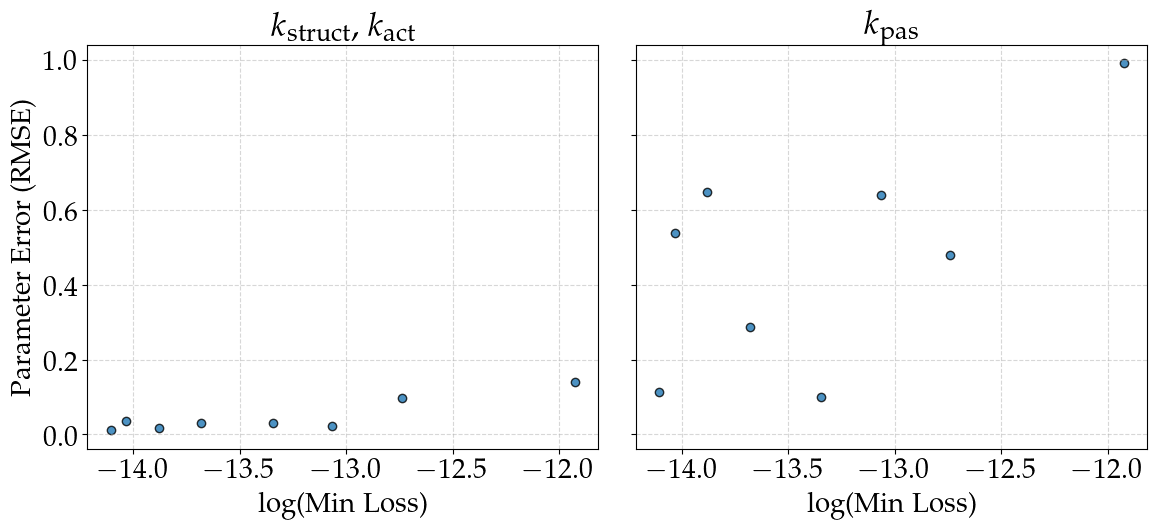

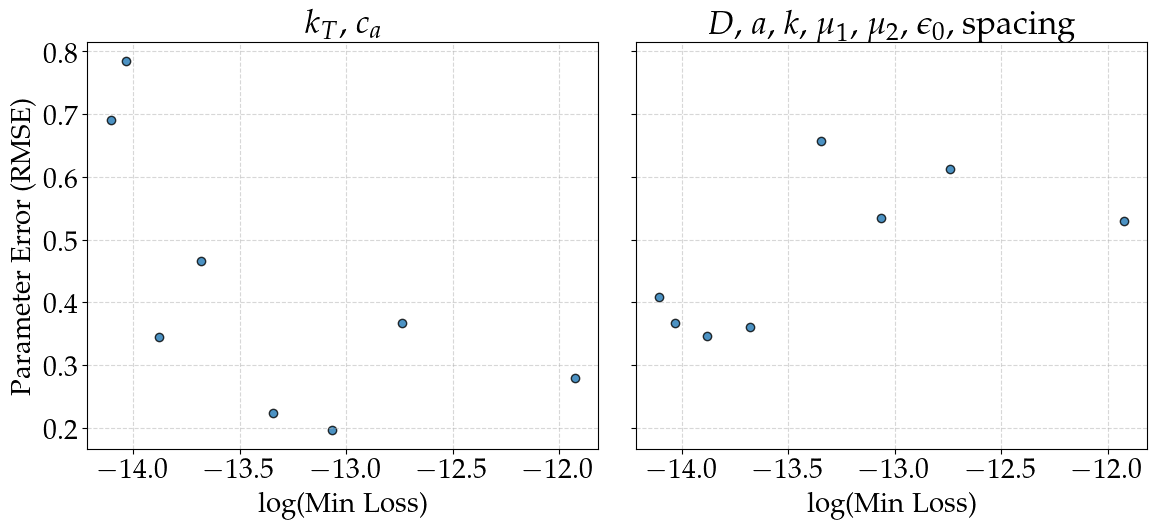

In [32]:
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true,
    selected_key_groups=[
        ['k_ij', 'k_a'],
        ['k_j']
    ],
    param_labels= param_labels
)
plot_loss_vs_param_error_multi_subplots(
    losses,
    params,
    params_true,
    selected_key_groups=[
        ['k_T', 'c_a'],electric_keys
    ],
    param_labels= param_labels
)


Available runs: 8


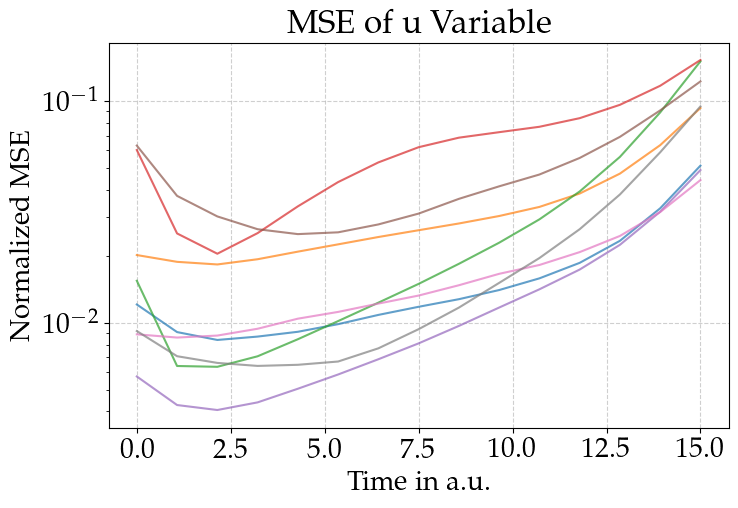

Available runs: 8


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


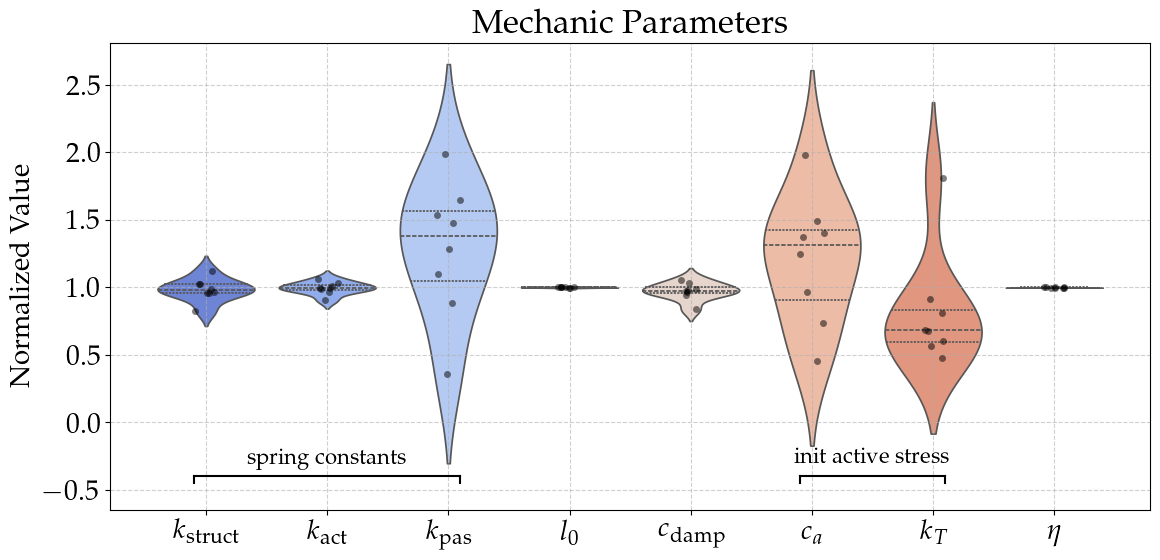

Available runs: 8


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


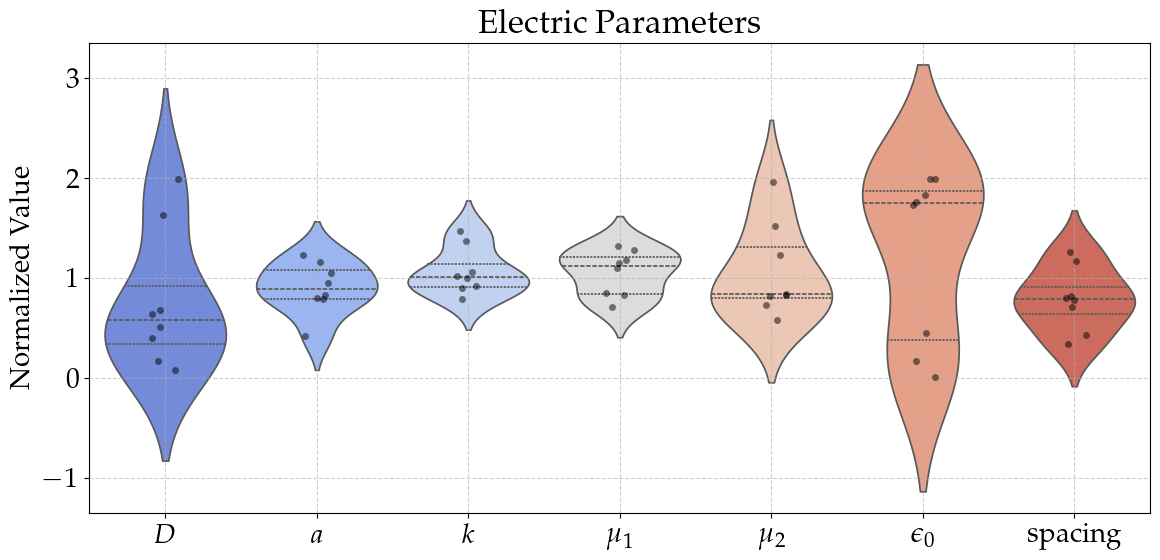

In [33]:
plot_u_mse_over_time(file_path_APAP_eta05)
violin_plot(file_path_APAP_eta05, mode="AP_AP", selected_keys=mech_keys,params_true=params_true, param_labels=param_labels,title = 'Mechanic Parameters')
violin_plot(file_path_APAP_eta05, mode="AP_AP", selected_keys=electric_keys,params_true=params_true, param_labels=param_labels,title  = 'Electric Parameters')

# non-Isotropic Fiber Orientation

In [34]:
file_path_APAP_etavar = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarTrue_modechaos.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim,losses, params= load_stat_data(file_path_APAP_etavar, mode)
print(u_sol.shape)
print("Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 35
(35, 15, 100, 100)
Mean Squared Errors:
u: 0.19738175900401317
v: 0.28769426096292505
T: 1.0128611046398548


In [35]:
# plot_u_error(file_path_APAP_etavar, run=0, mode='AP_AP')
# plot_T_error(file_path_APAP_etavar, run=0, params=params, params_true=params_true, mode='AP_AP')

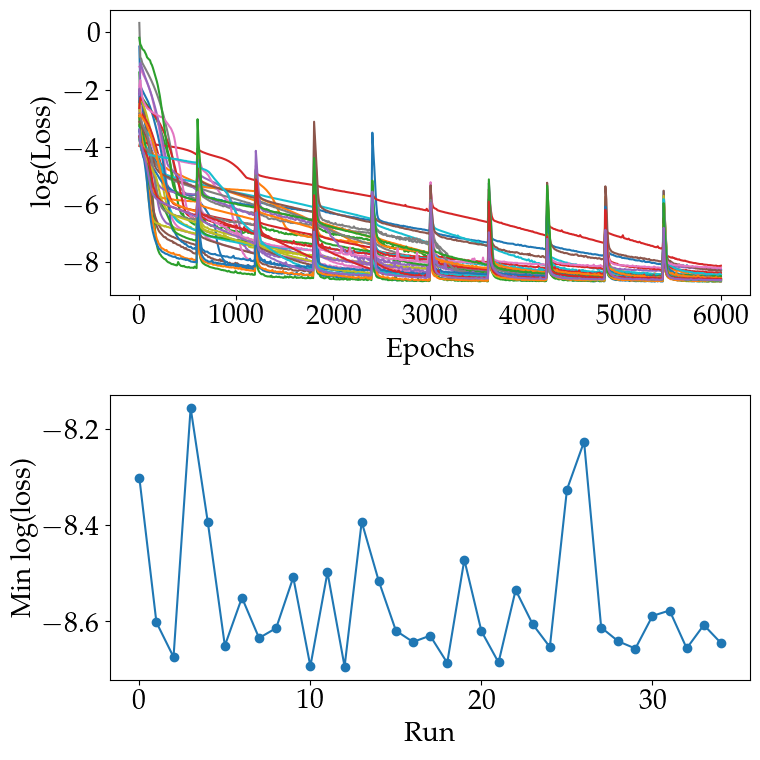

In [36]:
plot_loss_curves(losses)

Available runs: 35


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


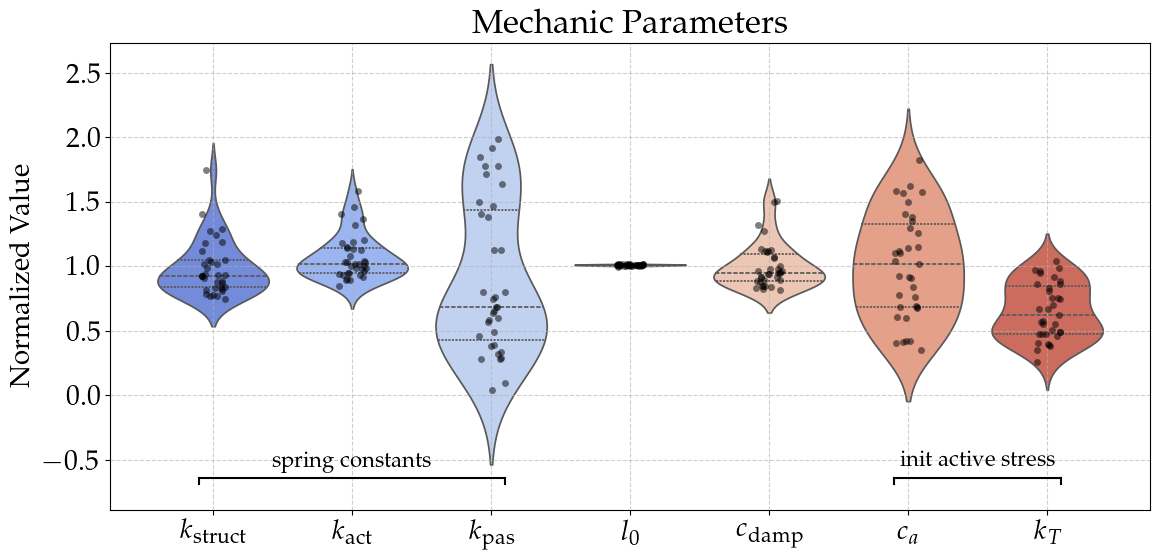

Available runs: 35


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


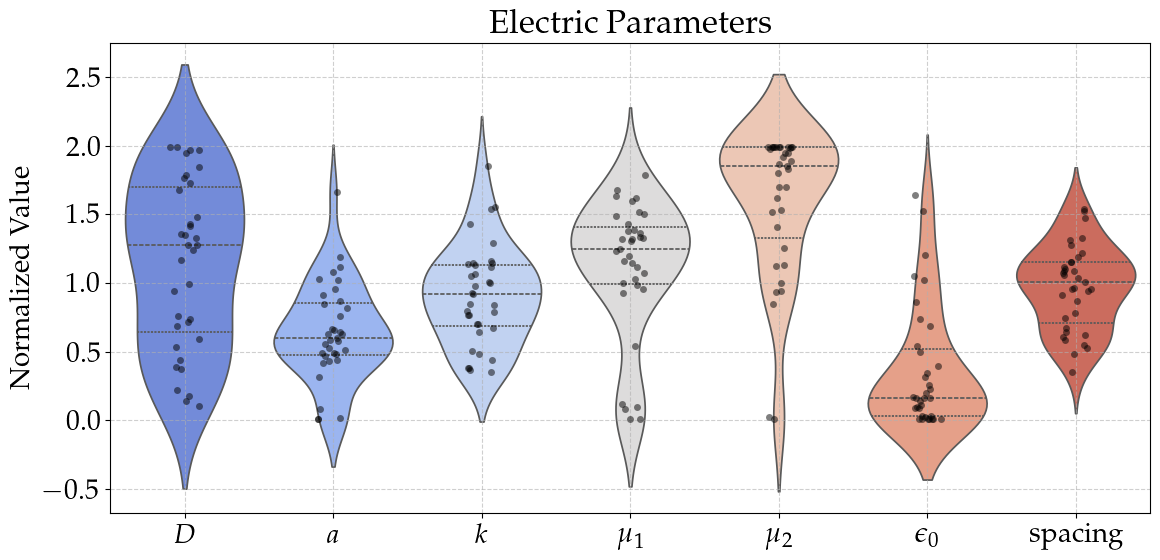

Available runs: 35


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


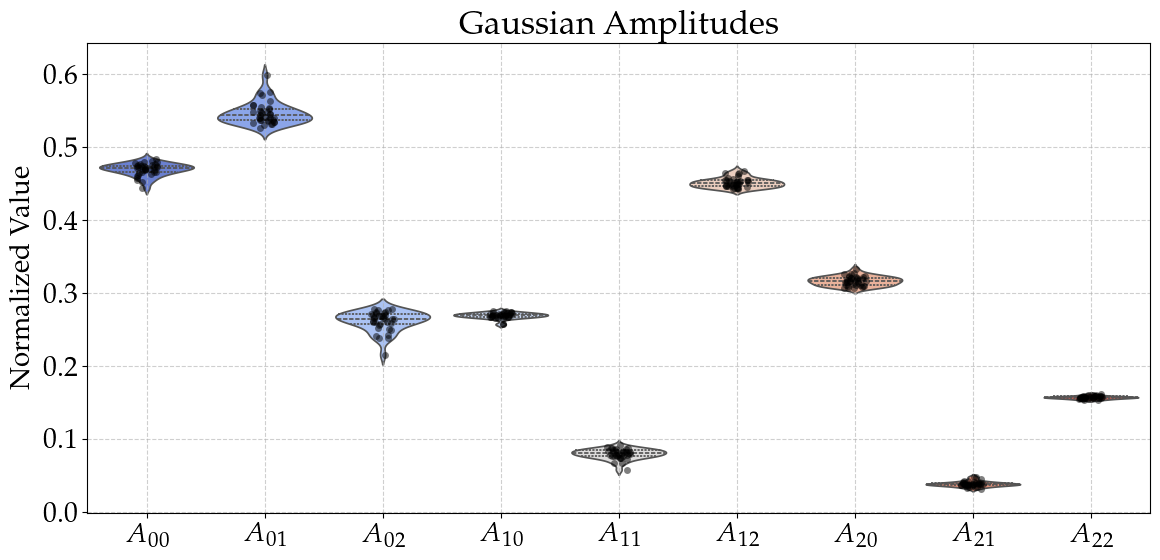

In [37]:
# plot_u_mse_over_time(file_path_APAP_etavar)
new_mech_keys = [k for k in mech_keys if k != 'n_0']
violin_plot(file_path_APAP_etavar, mode="AP_AP", selected_keys=new_mech_keys,params_true=params_true,param_labels=param_labels, title = 'Mechanic Parameters')
violin_plot(file_path_APAP_etavar, mode="AP_AP", selected_keys=electric_keys,params_true=params_true,param_labels=param_labels, title  = 'Electric Parameters')
violin_plot(file_path_APAP_etavar, mode="AP_AP", selected_keys=gaussian_keys,params_true=params_true,param_labels=param_labels, title  = 'Gaussian Amplitudes')

# Keep Electric Params True

In [53]:
file_path_APAPtrue_eta05 = '../data/SpringMassModel/FullDomain/TrueElectricParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modechaos.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses, params = load_stat_data(file_path_APAPtrue_eta05, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 26
Normalized Mean Squared Errors:
u: 0.05987202619164415
v: 0.15154173072004146
T: 0.23759180600613738


Available runs: 26
u_sol shape: (26, 15, 100, 100)


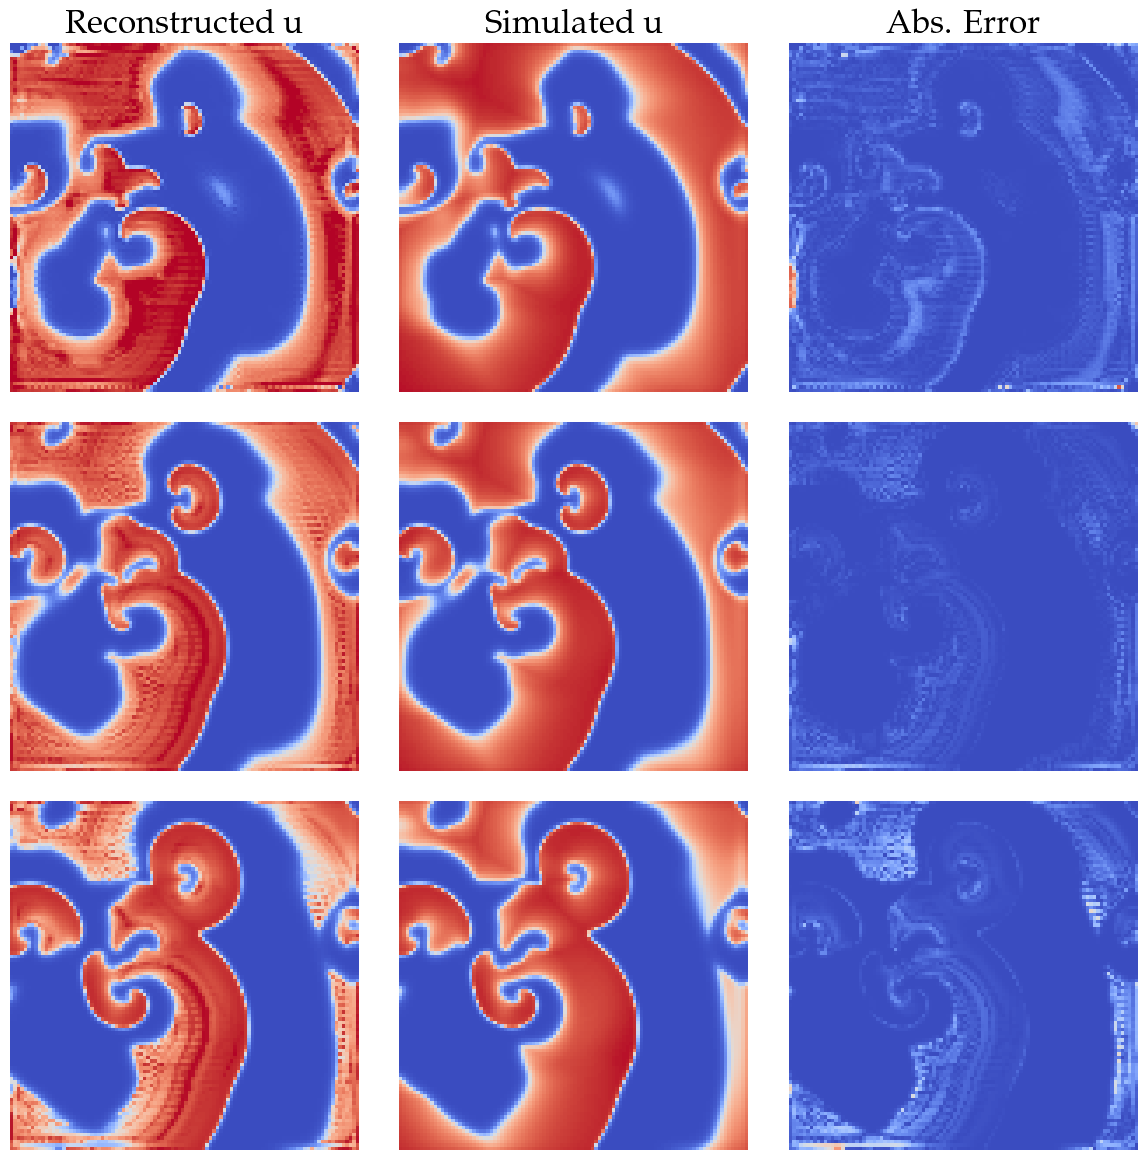

Mean Squared Error: 0.006047902884638275


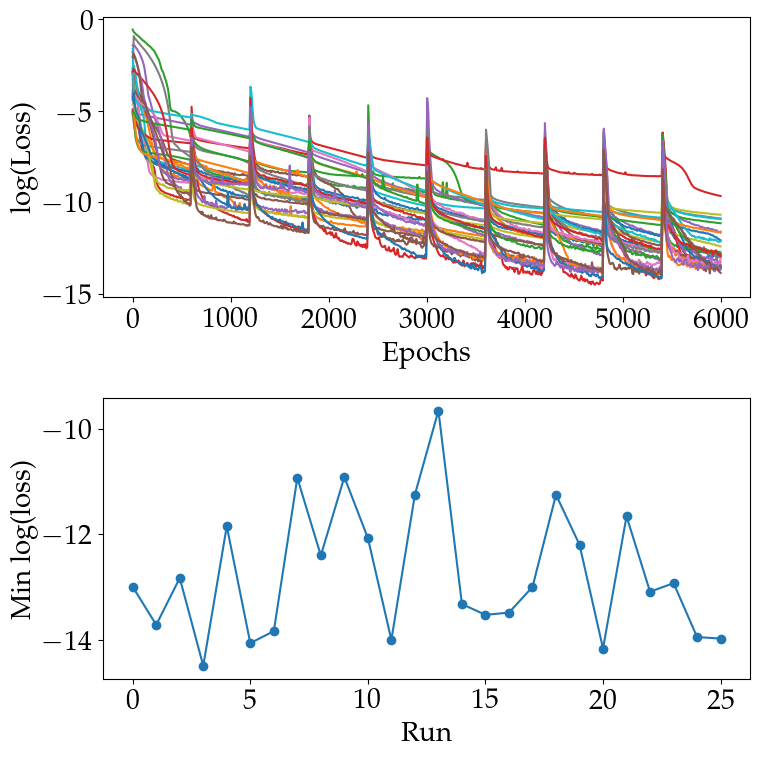

In [54]:
run=5

plot_u_error(file_path_APAPtrue_eta05, run)
plot_loss_curves(losses)

Available runs: 26


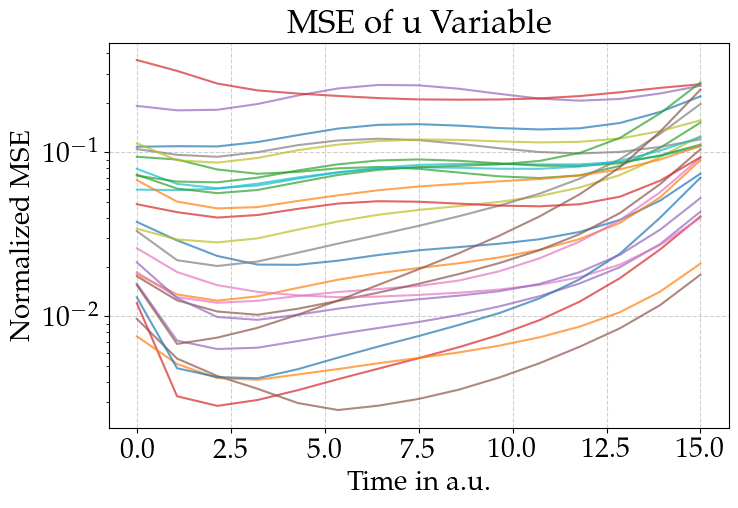

Available runs: 26


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


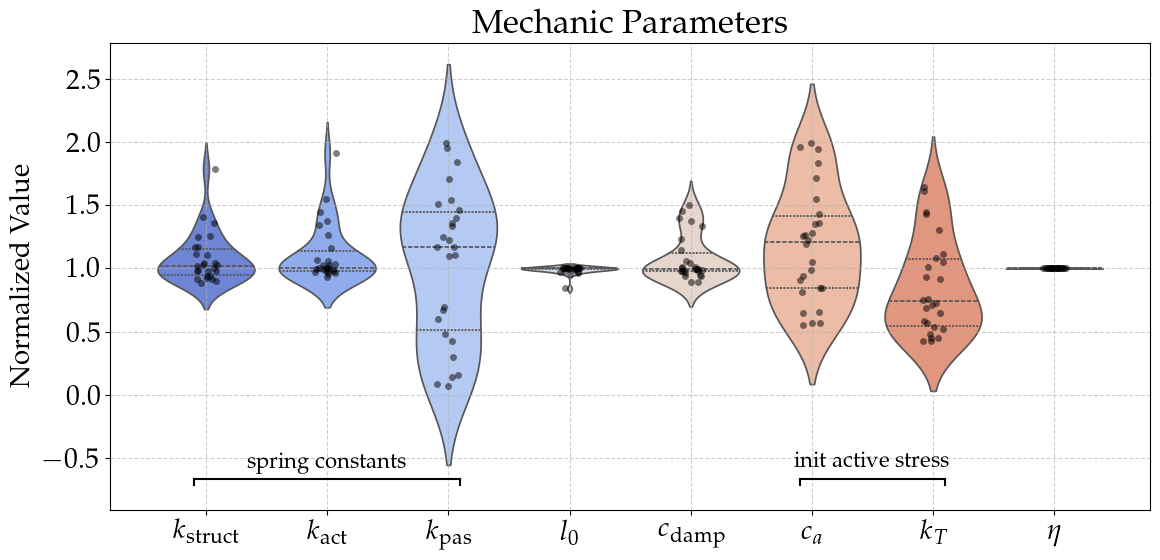

In [55]:
plot_u_mse_over_time(file_path_APAPtrue_eta05)
violin_plot(file_path_APAPtrue_eta05, mode="AP_AP", selected_keys=mech_keys,params_true=params_true, param_labels=param_labels,title = 'Mechanic Parameters')

# 2 Diffusion directions Isotropic

In [41]:
file_path_APAP_2Diff = '../data/SpringMassModel/FullDomain/FastSlowDiffIsotropic/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses , params= load_stat_data(file_path_APAP_2Diff, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))


Available runs: 20
Normalized Mean Squared Errors:
u: 0.17650259346149474
v: 0.3766594891887031
T: 0.34675714481588404


In [42]:
run = 5
# plot_u_error(file_path_APAP_2Diff, run)

In [43]:
# plot_u_mse_over_time(file_path_APAP_2Diff)
# violin_plot(file_path_APAP_2Diff, mode="AP_AP", selected_keys=mech_keys,params_true=params_true, title = 'Mechanic Parameters')
# violin_plot(file_path_APAP_2Diff, mode="AP_AP", selected_keys=electric_keys_2diff,params_true=params_true, title  = 'Electric Parameters')

# Single Spiral wave

In [44]:
file_path_APAP_spiral = '../data/SpringMassModel/FullDomain/Scroll/Stats/FullDomain_len25_lr25_tol099_keepdataTrue_keepparamsTrue_etavarFalse_modescroll.h5'

In [ ]:
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, losses,params = load_stat_data(file_path_APAP_spiral, mode)
print("Normalized Mean Squared Errors:")
print("u:", np.mean((u_sol - u_sim)**2)/np.mean(u_sol**2))
print("v:", np.mean((v_sol - v_sim)**2)/np.mean(v_sol**2))          
print("T:", np.mean((T_sol - T_sim)**2)/np.mean(T_sol**2))

Available runs: 34
Normalized Mean Squared Errors:
u: 0.10391211643032913
v: 0.3344573293123501
T: 0.1679562468041583


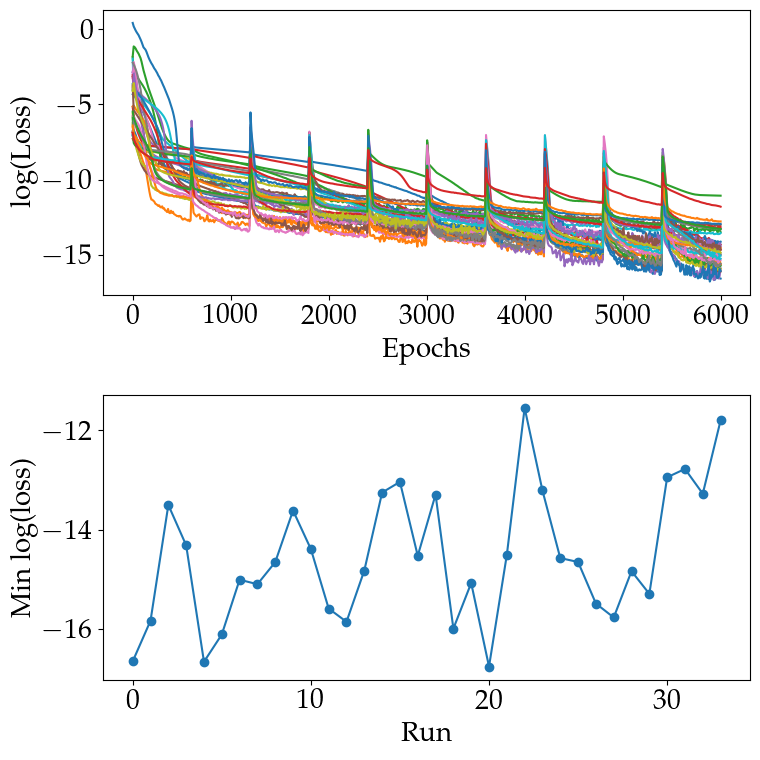

In [46]:
plot_loss_curves(losses)

Available runs: 34
u_sol shape: (34, 25, 100, 100)


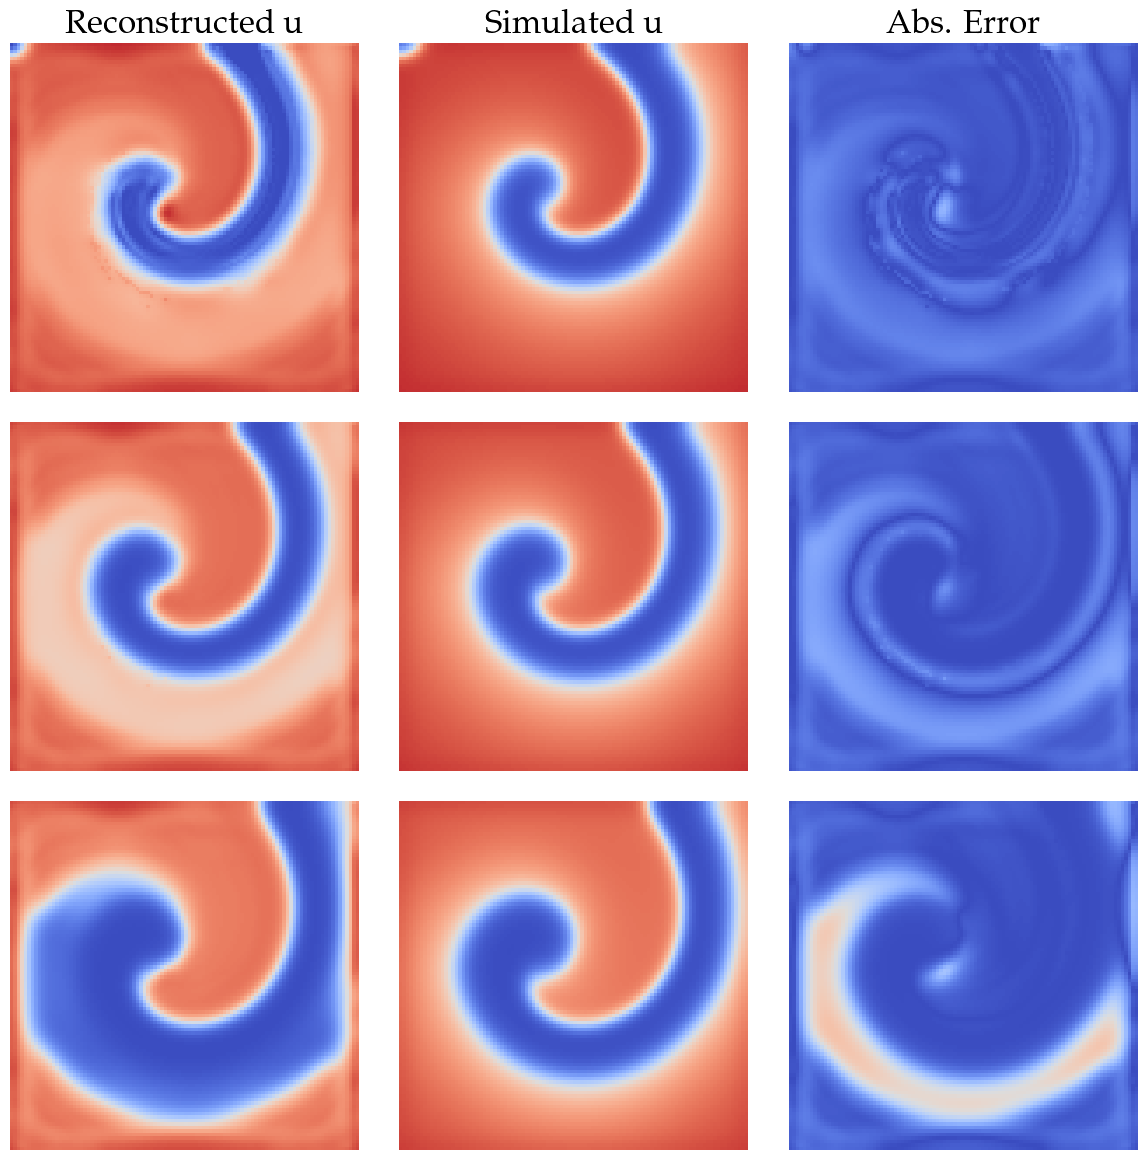

Mean Squared Error: 0.030562326926673447
Available runs: 34
T_sol shape: (34, 25, 100, 100)


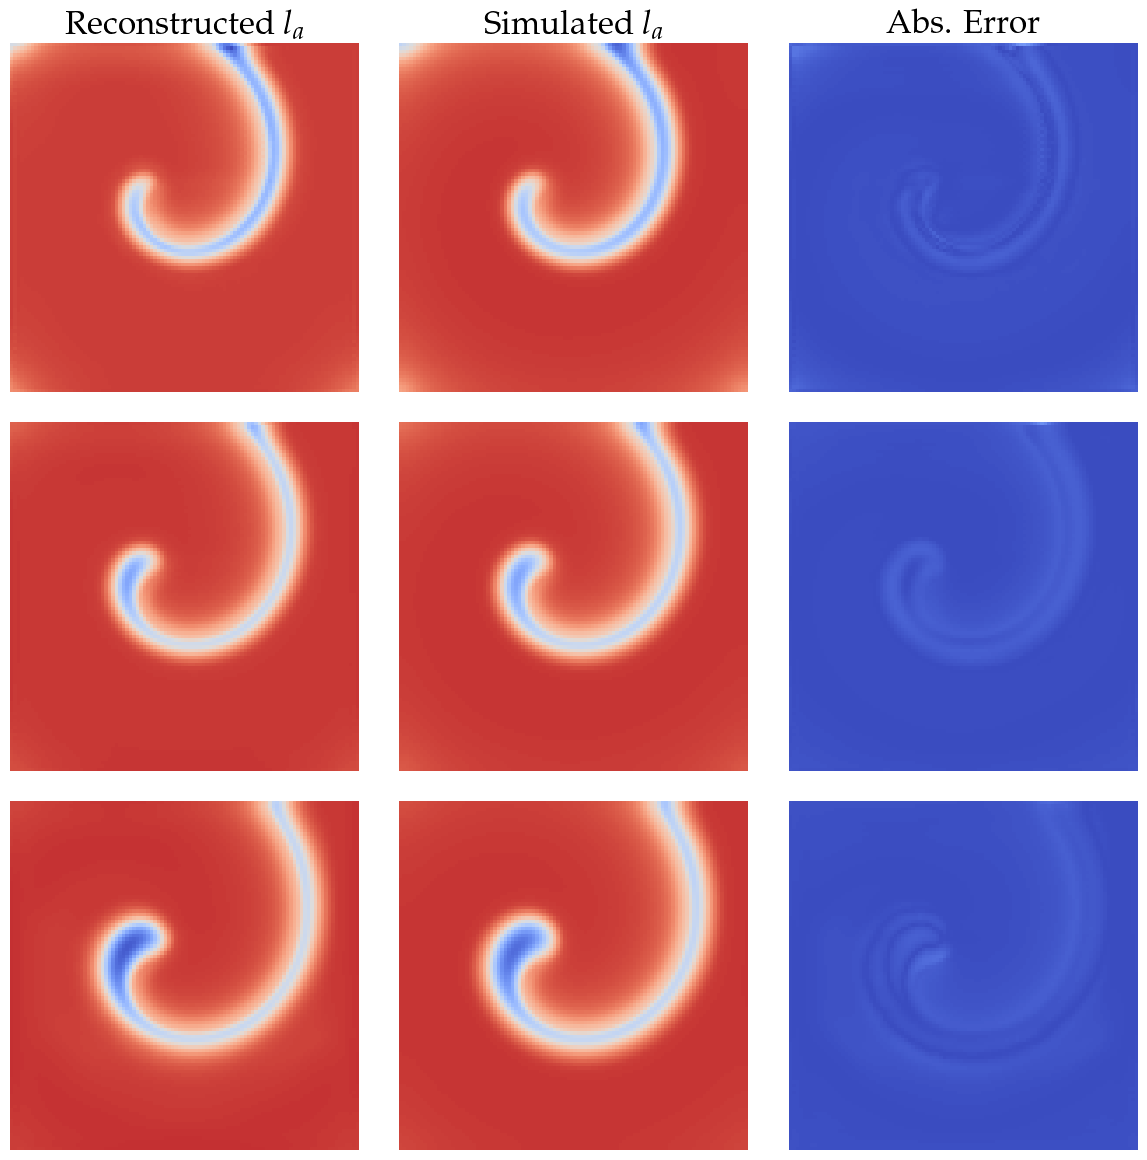

Mean Squared Error: 0.033396530819847295


In [57]:
run = 6
plot_u_error(file_path_APAP_spiral, run)
plot_T_error(file_path_APAP_spiral, run,params,params_true_scroll)

Available runs: 34


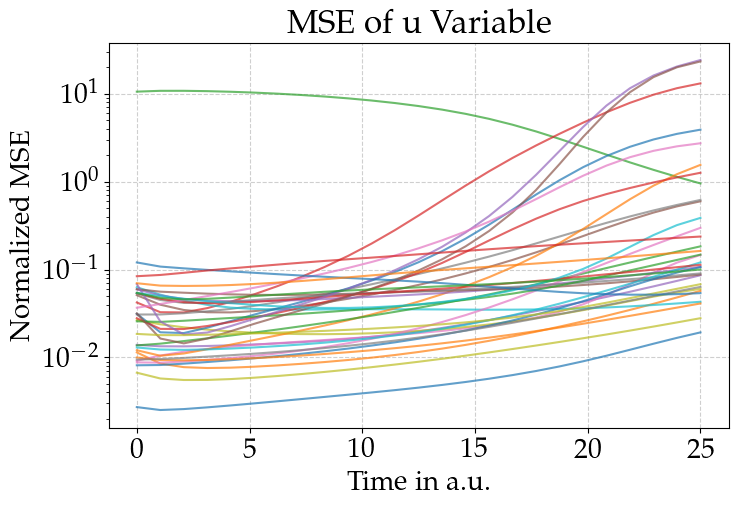

Available runs: 34


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


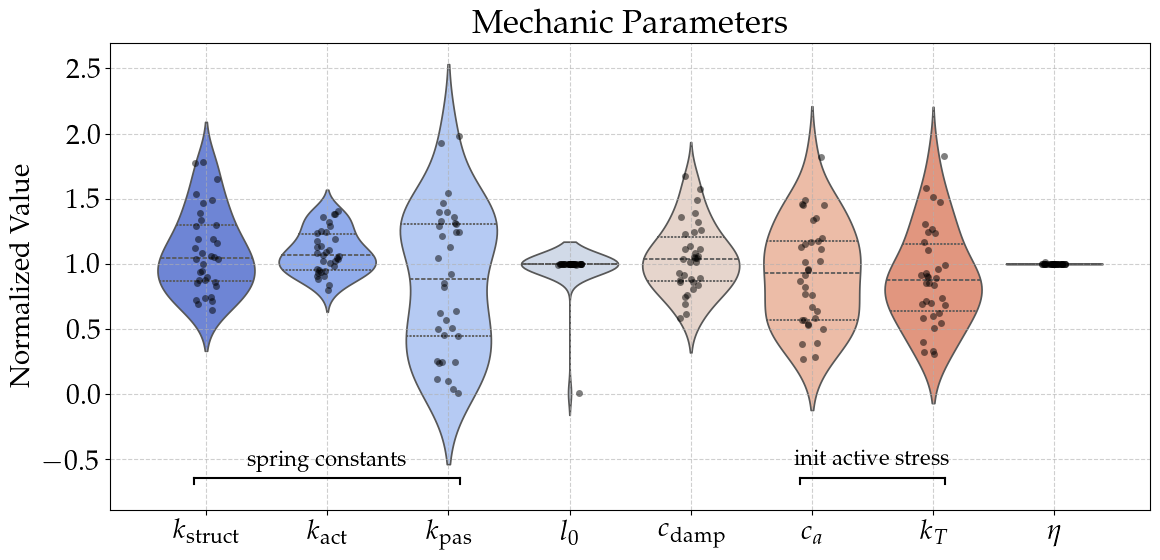

Available runs: 34


/tmp/ipykernel_2509921/929433124.py:162: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels)


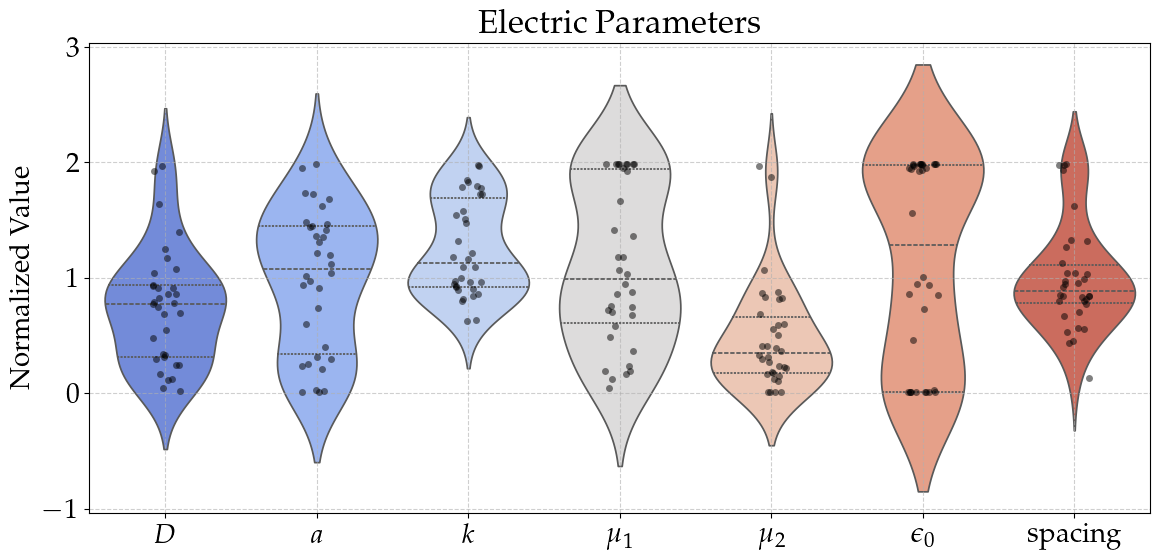

In [48]:
plot_u_mse_over_time(file_path_APAP_spiral)
violin_plot(file_path_APAP_spiral, mode="AP_AP", selected_keys=mech_keys,params_true=params_true_scroll, param_labels = param_labels,title = 'Mechanic Parameters')
violin_plot(file_path_APAP_spiral, mode="AP_AP", selected_keys=electric_keys,params_true=params_true_scroll, param_labels = param_labels,title  = 'Electric Parameters')